Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance Segmentation of Powder Particles and Satellites

This example will take you through the process of training a model to segment powder particles and visualizing the model predictions.

In [1]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

root = '../../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
ocean_syn = root + '../../../../ocean/projects/dmr200021p/sprice/synthetic_training/'
sys.path.append(root)

from ampis import data_utils, visualize, export_anno

%matplotlib inline

# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

# Loading Data
The process for training models for powder particles and satellites is identical. Enter the corresponding value depending on which model you want to train. <br />
The paths to individual images, and all annotation data are stored in the JSON files generated by the VGG image annotator.



In [2]:
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
json_path_train = Path(ocean_syn,'trainings','synthetic_training_satellite_a1.1.json')  # path to training data
json_path_val = Path(ocean_syn,'trainings', 'synthetic_validation_satellite_a1.0.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'


## Registration
Detectron2 requires that datasets be registered for later use.
Registration stores the name of the dataset and a function that can be used to retrieve the image paths and labels in a format that the model can use.

In [3]:
DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                     im_root=f,  # path to the training data json file
                                                                                                     dataset_class='Train'))  # indicates this is training data
# register the validation dataset
DatasetCatalog.register(dataset_valid, lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                                                im_root=f,  # path to validation data json file
                                                                                                dataset_class='Validation'))  # indicates this is validation data
                              
print(f'Registered Datasets: {DatasetCatalog.list()}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})

Registered Datasets: ['satellite_Train', 'satellite_Val']


## Verify images and annotations are loaded correctly
Also, this is a great time to admire my hand-drawn labels, which took sooooo long to do!
### Training Data

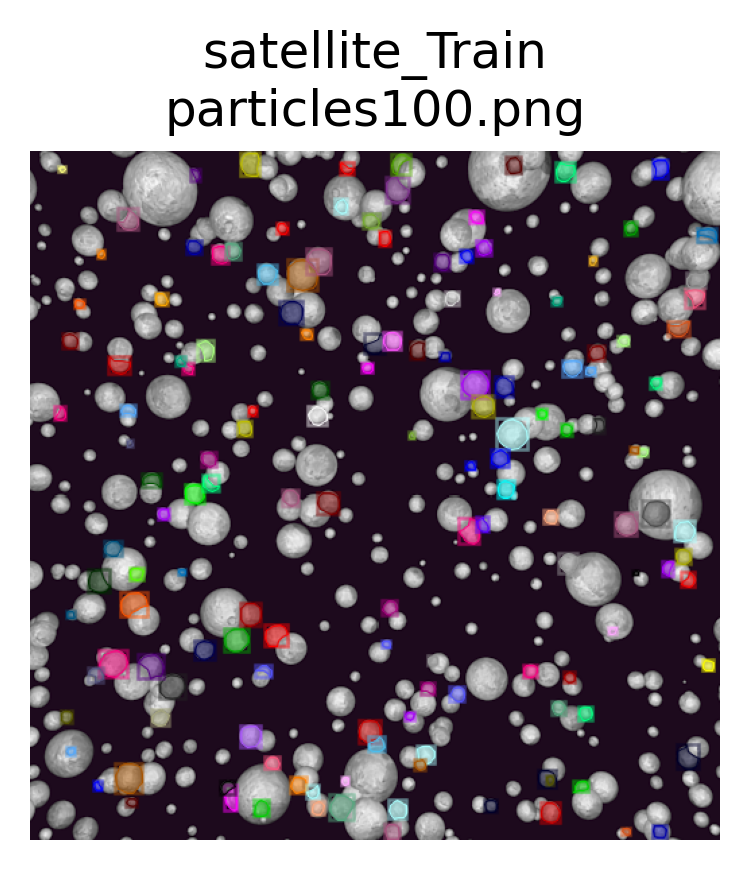

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles100.png
	num_instances: 148


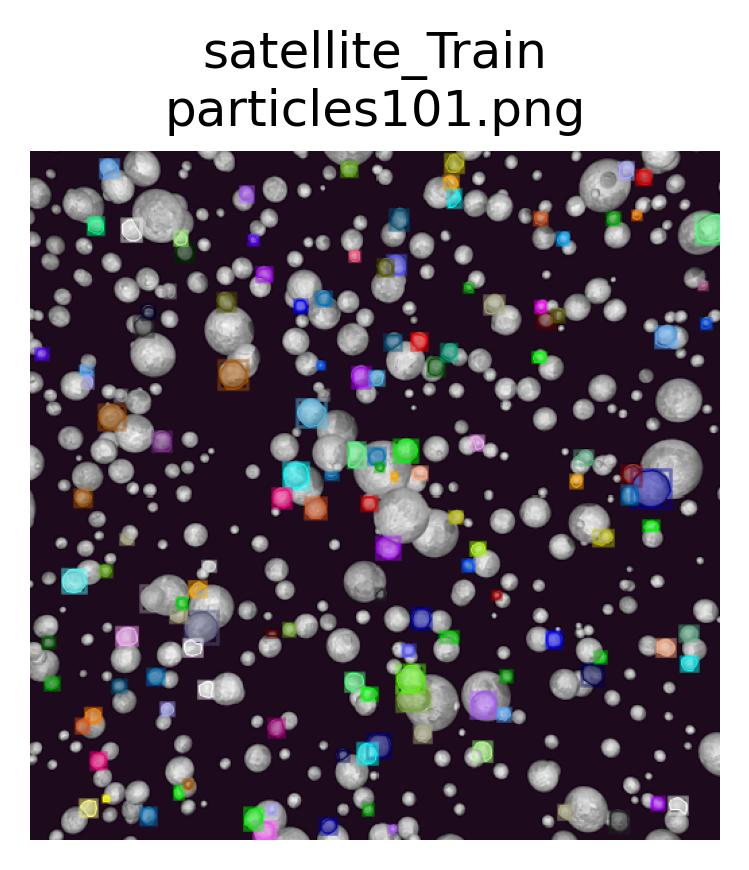

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles101.png
	num_instances: 139


In [4]:
#for i in np.random.choice(DatasetCatalog.get(dataset_train), 3, replace=False):
    #visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)
for i in DatasetCatalog.get(dataset_train):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)

### Validation Data

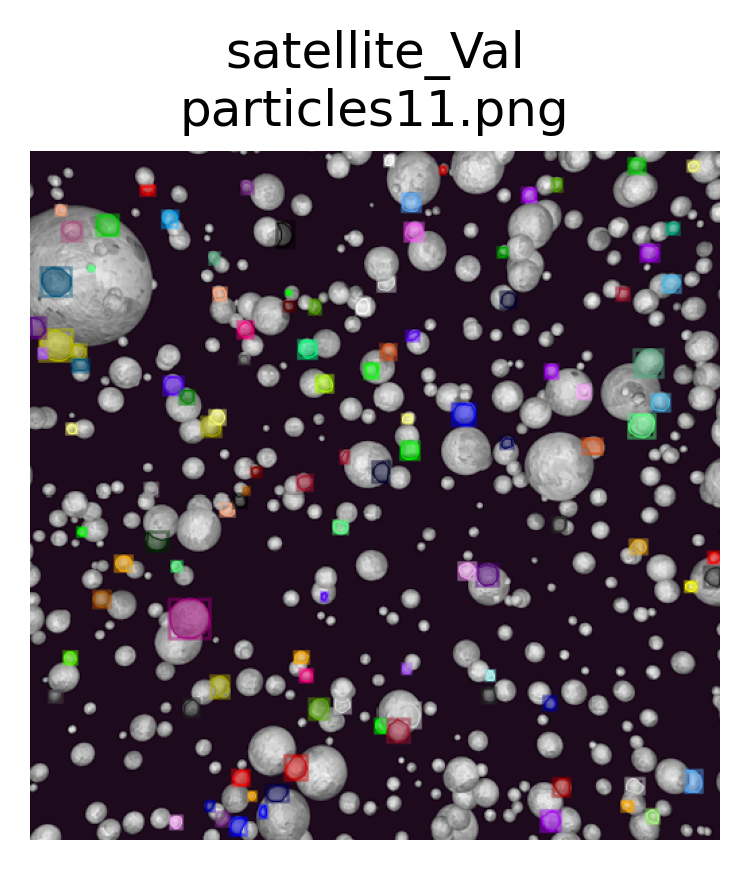

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles11.png
	num_instances: 110


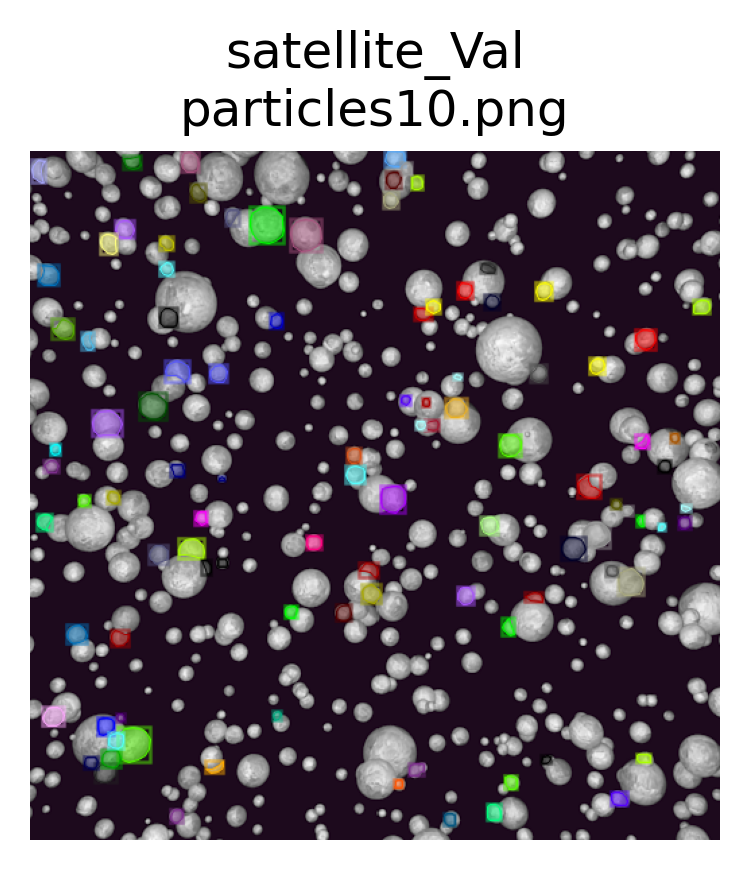

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles10.png
	num_instances: 101


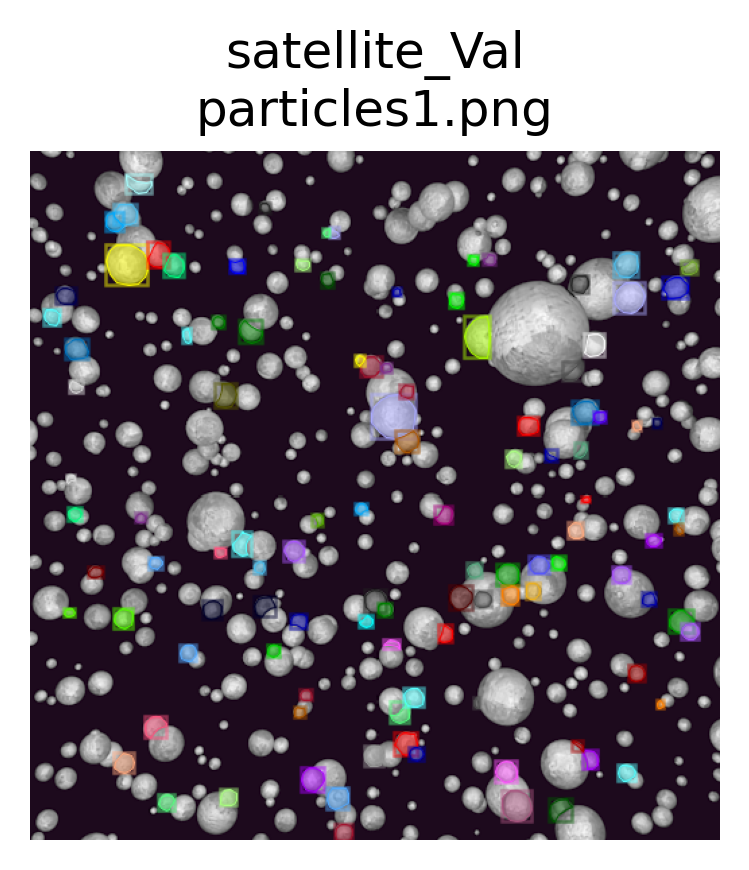

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/trainings/../images/a-lognormal-loc0.1-shape0.5/renders/particles1.png
	num_instances: 110


In [5]:
for i in DatasetCatalog.get(dataset_valid):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [6]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 15000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('..','..','models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path(ocean_syn,'Models', 'Synthetic_training_a1.1'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl


# Model Training
Once we have everything set up, training is very easy!

Note- this block will generate a huge wall of text.

In [ ]:
trainer = DefaultTrainer(cfg)  # create trainer object from cfg
trainer.resume_or_load(resume=False)  # start training from iteration 0
trainer.train()  # train the model!

[07/26 16:24:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/26 16:24:19 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[07/26 16:24:19 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| satellite  | 287          |
|            |              |
[07/26 16:24:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 16:24:19 d2.data.build]: Using training sampler TrainingSampler
[07/26 16:24:19 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[07/26 16:24:19 d2.data.common]: Serialized dataset takes 0.08 MiB
WARNING [07/26 16:24:19 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


/jet/home/sprice/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07/26 16:24:19 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/26 16:24:19 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

[07/26 16:24:50 d2.utils.events]:  eta: 0:32:25  iter: 219  total_loss: 1.542  loss_cls: 0.2087  loss_box_reg: 0.3813  loss_mask: 0.3637  loss_rpn_cls: 0.2445  loss_rpn_loc: 0.3133  time: 0.1322  data_time: 0.0151  lr: 0.0043956  max_mem: 1547M
[07/26 16:24:53 d2.utils.events]:  eta: 0:32:22  iter: 239  total_loss: 1.442  loss_cls: 0.2205  loss_box_reg: 0.3753  loss_mask: 0.3316  loss_rpn_cls: 0.239  loss_rpn_loc: 0.2849  time: 0.1321  data_time: 0.0145  lr: 0.0047952  max_mem: 1547M
[07/26 16:24:56 d2.utils.events]:  eta: 0:32:20  iter: 259  total_loss: 1.346  loss_cls: 0.1887  loss_box_reg: 0.3424  loss_mask: 0.337  loss_rpn_cls: 0.2098  loss_rpn_loc: 0.2739  time: 0.1321  data_time: 0.0140  lr: 0.0051948  max_mem: 1547M
[07/26 16:24:58 d2.utils.events]:  eta: 0:32:18  iter: 279  total_loss: 1.431  loss_cls: 0.2115  loss_box_reg: 0.3708  loss_mask: 0.3303  loss_rpn_cls: 0.2159  loss_rpn_loc: 0.2819  time: 0.1321  data_time: 0.0150  lr: 0.0055944  max_mem: 1547M
[07/26 16:25:01 d2.uti

[07/26 16:26:19 d2.utils.events]:  eta: 0:31:01  iter: 879  total_loss: 0.9445  loss_cls: 0.1191  loss_box_reg: 0.2607  loss_mask: 0.1775  loss_rpn_cls: 0.1235  loss_rpn_loc: 0.2661  time: 0.1331  data_time: 0.0146  lr: 0.017582  max_mem: 1547M
[07/26 16:26:22 d2.utils.events]:  eta: 0:30:59  iter: 899  total_loss: 0.9429  loss_cls: 0.1197  loss_box_reg: 0.2531  loss_mask: 0.1704  loss_rpn_cls: 0.09691  loss_rpn_loc: 0.2878  time: 0.1331  data_time: 0.0153  lr: 0.017982  max_mem: 1547M
[07/26 16:26:25 d2.utils.events]:  eta: 0:30:56  iter: 919  total_loss: 0.9288  loss_cls: 0.1194  loss_box_reg: 0.2571  loss_mask: 0.1857  loss_rpn_cls: 0.1132  loss_rpn_loc: 0.2725  time: 0.1331  data_time: 0.0148  lr: 0.018382  max_mem: 1547M
[07/26 16:26:27 d2.utils.events]:  eta: 0:30:52  iter: 939  total_loss: 0.9149  loss_cls: 0.1114  loss_box_reg: 0.264  loss_mask: 0.1768  loss_rpn_cls: 0.121  loss_rpn_loc: 0.2551  time: 0.1330  data_time: 0.0151  lr: 0.018781  max_mem: 1547M
[07/26 16:26:30 d2.ut

[07/26 16:27:48 d2.utils.events]:  eta: 0:29:28  iter: 1539  total_loss: 0.6862  loss_cls: 0.08244  loss_box_reg: 0.1932  loss_mask: 0.1211  loss_rpn_cls: 0.0748  loss_rpn_loc: 0.2146  time: 0.1326  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:27:51 d2.utils.events]:  eta: 0:29:25  iter: 1559  total_loss: 0.6608  loss_cls: 0.08797  loss_box_reg: 0.1946  loss_mask: 0.1208  loss_rpn_cls: 0.05455  loss_rpn_loc: 0.1966  time: 0.1326  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:27:53 d2.utils.events]:  eta: 0:29:21  iter: 1579  total_loss: 0.6725  loss_cls: 0.08308  loss_box_reg: 0.1871  loss_mask: 0.1172  loss_rpn_cls: 0.06154  loss_rpn_loc: 0.2016  time: 0.1326  data_time: 0.0141  lr: 0.02  max_mem: 1547M
[07/26 16:27:56 d2.utils.events]:  eta: 0:29:17  iter: 1599  total_loss: 0.693  loss_cls: 0.0878  loss_box_reg: 0.1989  loss_mask: 0.1162  loss_rpn_cls: 0.06767  loss_rpn_loc: 0.222  time: 0.1325  data_time: 0.0139  lr: 0.02  max_mem: 1547M
[07/26 16:27:59 d2.utils.eve

[07/26 16:29:18 d2.utils.events]:  eta: 0:28:01  iter: 2199  total_loss: 0.52  loss_cls: 0.06373  loss_box_reg: 0.1564  loss_mask: 0.09041  loss_rpn_cls: 0.03893  loss_rpn_loc: 0.168  time: 0.1326  data_time: 0.0149  lr: 0.02  max_mem: 1547M
[07/26 16:29:21 d2.utils.events]:  eta: 0:27:59  iter: 2219  total_loss: 0.5336  loss_cls: 0.05834  loss_box_reg: 0.1599  loss_mask: 0.09189  loss_rpn_cls: 0.0441  loss_rpn_loc: 0.164  time: 0.1326  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:29:24 d2.utils.events]:  eta: 0:27:56  iter: 2239  total_loss: 0.5243  loss_cls: 0.06108  loss_box_reg: 0.1524  loss_mask: 0.09048  loss_rpn_cls: 0.04136  loss_rpn_loc: 0.1738  time: 0.1326  data_time: 0.0142  lr: 0.02  max_mem: 1547M
[07/26 16:29:26 d2.utils.events]:  eta: 0:27:54  iter: 2259  total_loss: 0.5442  loss_cls: 0.05467  loss_box_reg: 0.1595  loss_mask: 0.09782  loss_rpn_cls: 0.05072  loss_rpn_loc: 0.177  time: 0.1326  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:29:29 d2.utils.e

[07/26 16:30:47 d2.utils.events]:  eta: 0:26:37  iter: 2859  total_loss: 0.4904  loss_cls: 0.05507  loss_box_reg: 0.1507  loss_mask: 0.08485  loss_rpn_cls: 0.04112  loss_rpn_loc: 0.1591  time: 0.1326  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:30:50 d2.utils.events]:  eta: 0:26:35  iter: 2879  total_loss: 0.4946  loss_cls: 0.06062  loss_box_reg: 0.157  loss_mask: 0.08444  loss_rpn_cls: 0.03259  loss_rpn_loc: 0.1627  time: 0.1326  data_time: 0.0145  lr: 0.02  max_mem: 1547M
[07/26 16:30:52 d2.utils.events]:  eta: 0:26:32  iter: 2899  total_loss: 0.4864  loss_cls: 0.05162  loss_box_reg: 0.1526  loss_mask: 0.07974  loss_rpn_cls: 0.04034  loss_rpn_loc: 0.166  time: 0.1326  data_time: 0.0156  lr: 0.02  max_mem: 1547M
[07/26 16:30:55 d2.utils.events]:  eta: 0:26:29  iter: 2919  total_loss: 0.4486  loss_cls: 0.05052  loss_box_reg: 0.1419  loss_mask: 0.08044  loss_rpn_cls: 0.03177  loss_rpn_loc: 0.1537  time: 0.1326  data_time: 0.0144  lr: 0.02  max_mem: 1547M
[07/26 16:30:58 d2.uti

[07/26 16:32:16 d2.utils.events]:  eta: 0:25:13  iter: 3519  total_loss: 0.4261  loss_cls: 0.04471  loss_box_reg: 0.1225  loss_mask: 0.07231  loss_rpn_cls: 0.03621  loss_rpn_loc: 0.1445  time: 0.1325  data_time: 0.0145  lr: 0.02  max_mem: 1547M
[07/26 16:32:19 d2.utils.events]:  eta: 0:25:11  iter: 3539  total_loss: 0.4138  loss_cls: 0.04681  loss_box_reg: 0.1216  loss_mask: 0.07171  loss_rpn_cls: 0.03593  loss_rpn_loc: 0.1431  time: 0.1325  data_time: 0.0150  lr: 0.02  max_mem: 1547M
[07/26 16:32:22 d2.utils.events]:  eta: 0:25:10  iter: 3559  total_loss: 0.4139  loss_cls: 0.04675  loss_box_reg: 0.1205  loss_mask: 0.07235  loss_rpn_cls: 0.0313  loss_rpn_loc: 0.1453  time: 0.1326  data_time: 0.0141  lr: 0.02  max_mem: 1547M
[07/26 16:32:24 d2.utils.events]:  eta: 0:25:07  iter: 3579  total_loss: 0.4258  loss_cls: 0.04785  loss_box_reg: 0.1201  loss_mask: 0.0709  loss_rpn_cls: 0.04142  loss_rpn_loc: 0.1456  time: 0.1326  data_time: 0.0145  lr: 0.02  max_mem: 1547M
[07/26 16:32:27 d2.uti

[07/26 16:33:46 d2.utils.events]:  eta: 0:23:46  iter: 4179  total_loss: 0.3935  loss_cls: 0.03795  loss_box_reg: 0.114  loss_mask: 0.06627  loss_rpn_cls: 0.02323  loss_rpn_loc: 0.146  time: 0.1326  data_time: 0.0156  lr: 0.02  max_mem: 1547M
[07/26 16:33:49 d2.utils.events]:  eta: 0:23:44  iter: 4199  total_loss: 0.387  loss_cls: 0.04454  loss_box_reg: 0.1122  loss_mask: 0.06519  loss_rpn_cls: 0.03043  loss_rpn_loc: 0.1341  time: 0.1326  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:33:52 d2.utils.events]:  eta: 0:23:41  iter: 4219  total_loss: 0.4268  loss_cls: 0.0477  loss_box_reg: 0.1199  loss_mask: 0.06961  loss_rpn_cls: 0.03345  loss_rpn_loc: 0.1482  time: 0.1326  data_time: 0.0147  lr: 0.02  max_mem: 1547M
[07/26 16:33:54 d2.utils.events]:  eta: 0:23:37  iter: 4239  total_loss: 0.4185  loss_cls: 0.04596  loss_box_reg: 0.1204  loss_mask: 0.06668  loss_rpn_cls: 0.02714  loss_rpn_loc: 0.1425  time: 0.1326  data_time: 0.0141  lr: 0.02  max_mem: 1547M
[07/26 16:33:57 d2.utils

[07/26 16:35:15 d2.utils.events]:  eta: 0:22:21  iter: 4839  total_loss: 0.3934  loss_cls: 0.03928  loss_box_reg: 0.1131  loss_mask: 0.0642  loss_rpn_cls: 0.03343  loss_rpn_loc: 0.1414  time: 0.1327  data_time: 0.0143  lr: 0.02  max_mem: 1547M
[07/26 16:35:18 d2.utils.events]:  eta: 0:22:19  iter: 4859  total_loss: 0.3612  loss_cls: 0.02863  loss_box_reg: 0.1029  loss_mask: 0.06338  loss_rpn_cls: 0.02325  loss_rpn_loc: 0.1325  time: 0.1327  data_time: 0.0163  lr: 0.02  max_mem: 1547M
[07/26 16:35:21 d2.utils.events]:  eta: 0:22:15  iter: 4879  total_loss: 0.3866  loss_cls: 0.04005  loss_box_reg: 0.1121  loss_mask: 0.06297  loss_rpn_cls: 0.03208  loss_rpn_loc: 0.1407  time: 0.1327  data_time: 0.0141  lr: 0.02  max_mem: 1547M
[07/26 16:35:23 d2.utils.events]:  eta: 0:22:12  iter: 4899  total_loss: 0.3934  loss_cls: 0.04074  loss_box_reg: 0.1167  loss_mask: 0.06615  loss_rpn_cls: 0.02886  loss_rpn_loc: 0.138  time: 0.1327  data_time: 0.0148  lr: 0.02  max_mem: 1547M
[07/26 16:35:26 d2.uti

[07/26 16:36:44 d2.utils.events]:  eta: 0:20:53  iter: 5499  total_loss: 0.357  loss_cls: 0.03662  loss_box_reg: 0.1137  loss_mask: 0.05877  loss_rpn_cls: 0.02012  loss_rpn_loc: 0.123  time: 0.1327  data_time: 0.0149  lr: 0.02  max_mem: 1547M
[07/26 16:36:47 d2.utils.events]:  eta: 0:20:51  iter: 5519  total_loss: 0.3637  loss_cls: 0.03526  loss_box_reg: 0.107  loss_mask: 0.06282  loss_rpn_cls: 0.0291  loss_rpn_loc: 0.1174  time: 0.1327  data_time: 0.0140  lr: 0.02  max_mem: 1547M
[07/26 16:36:50 d2.utils.events]:  eta: 0:20:49  iter: 5539  total_loss: 0.3353  loss_cls: 0.02855  loss_box_reg: 0.1008  loss_mask: 0.06256  loss_rpn_cls: 0.02346  loss_rpn_loc: 0.119  time: 0.1327  data_time: 0.0143  lr: 0.02  max_mem: 1547M
[07/26 16:36:52 d2.utils.events]:  eta: 0:20:48  iter: 5559  total_loss: 0.3311  loss_cls: 0.0303  loss_box_reg: 0.0948  loss_mask: 0.05787  loss_rpn_cls: 0.021  loss_rpn_loc: 0.122  time: 0.1327  data_time: 0.0159  lr: 0.02  max_mem: 1547M
[07/26 16:36:55 d2.utils.even

[07/26 16:38:14 d2.utils.events]:  eta: 0:19:32  iter: 6159  total_loss: 0.336  loss_cls: 0.03511  loss_box_reg: 0.09057  loss_mask: 0.05633  loss_rpn_cls: 0.02506  loss_rpn_loc: 0.12  time: 0.1328  data_time: 0.0153  lr: 0.02  max_mem: 1547M
[07/26 16:38:16 d2.utils.events]:  eta: 0:19:28  iter: 6179  total_loss: 0.3209  loss_cls: 0.02903  loss_box_reg: 0.09363  loss_mask: 0.05752  loss_rpn_cls: 0.01599  loss_rpn_loc: 0.1166  time: 0.1328  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:38:19 d2.utils.events]:  eta: 0:19:26  iter: 6199  total_loss: 0.3241  loss_cls: 0.0232  loss_box_reg: 0.102  loss_mask: 0.05922  loss_rpn_cls: 0.02053  loss_rpn_loc: 0.1168  time: 0.1327  data_time: 0.0142  lr: 0.02  max_mem: 1547M
[07/26 16:38:21 d2.utils.events]:  eta: 0:19:23  iter: 6219  total_loss: 0.3378  loss_cls: 0.03251  loss_box_reg: 0.101  loss_mask: 0.05797  loss_rpn_cls: 0.02365  loss_rpn_loc: 0.1197  time: 0.1327  data_time: 0.0142  lr: 0.02  max_mem: 1547M
[07/26 16:38:24 d2.utils

[07/26 16:39:42 d2.utils.events]:  eta: 0:18:03  iter: 6819  total_loss: 0.3071  loss_cls: 0.02909  loss_box_reg: 0.09215  loss_mask: 0.05083  loss_rpn_cls: 0.01871  loss_rpn_loc: 0.1142  time: 0.1328  data_time: 0.0135  lr: 0.02  max_mem: 1547M
[07/26 16:39:45 d2.utils.events]:  eta: 0:18:01  iter: 6839  total_loss: 0.3094  loss_cls: 0.03011  loss_box_reg: 0.09753  loss_mask: 0.0518  loss_rpn_cls: 0.01743  loss_rpn_loc: 0.1144  time: 0.1328  data_time: 0.0151  lr: 0.02  max_mem: 1547M
[07/26 16:39:48 d2.utils.events]:  eta: 0:17:58  iter: 6859  total_loss: 0.3031  loss_cls: 0.02362  loss_box_reg: 0.08882  loss_mask: 0.05031  loss_rpn_cls: 0.02239  loss_rpn_loc: 0.111  time: 0.1328  data_time: 0.0146  lr: 0.02  max_mem: 1547M
[07/26 16:39:51 d2.utils.events]:  eta: 0:17:55  iter: 6879  total_loss: 0.2957  loss_cls: 0.02566  loss_box_reg: 0.08582  loss_mask: 0.05148  loss_rpn_cls: 0.0237  loss_rpn_loc: 0.1087  time: 0.1328  data_time: 0.0155  lr: 0.02  max_mem: 1547M
[07/26 16:39:54 d2.

[07/26 16:41:12 d2.utils.events]:  eta: 0:16:34  iter: 7479  total_loss: 0.2914  loss_cls: 0.02568  loss_box_reg: 0.08408  loss_mask: 0.05465  loss_rpn_cls: 0.02244  loss_rpn_loc: 0.109  time: 0.1329  data_time: 0.0143  lr: 0.02  max_mem: 1547M
[07/26 16:41:15 d2.utils.events]:  eta: 0:16:32  iter: 7499  total_loss: 0.2865  loss_cls: 0.02579  loss_box_reg: 0.0893  loss_mask: 0.05104  loss_rpn_cls: 0.01691  loss_rpn_loc: 0.1082  time: 0.1328  data_time: 0.0150  lr: 0.02  max_mem: 1547M
[07/26 16:41:18 d2.utils.events]:  eta: 0:16:29  iter: 7519  total_loss: 0.2892  loss_cls: 0.02481  loss_box_reg: 0.08322  loss_mask: 0.05352  loss_rpn_cls: 0.01274  loss_rpn_loc: 0.1078  time: 0.1328  data_time: 0.0144  lr: 0.02  max_mem: 1547M
[07/26 16:41:20 d2.utils.events]:  eta: 0:16:26  iter: 7539  total_loss: 0.2853  loss_cls: 0.02725  loss_box_reg: 0.08548  loss_mask: 0.05209  loss_rpn_cls: 0.01368  loss_rpn_loc: 0.103  time: 0.1329  data_time: 0.0142  lr: 0.02  max_mem: 1547M
[07/26 16:41:24 d2.

# Visualizing model predictions
We will view the model predictions on the training and validation set.

In [8]:
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

## Generating predictions on new images is simple.
We will load a new image (not included in either dataset) and generate predictions.
Note that we do not have labels for this image and do not need to register it to a dataset.

In [9]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


AttributeError: 'NoneType' object has no attribute 'shape'

In [13]:
path = ocean_syn + 'images/a-lognormal-loc0.1-shape0.5/renders'
files = os.listdir(path)
img_names = []
for f in files:
    if f.split('.')[0] != 'particles103' and f.split('.')[0] != 'particles129' and f.split('.')[0] != 'particles159' and f.split('.')[0] != 'particles180':
        img_names.append(f.split('.')[0])
'''for f in img_names:
    print("Annotating: " + f)
    img_path = Path('..', 'data','images_png', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    export1 = export_anno.make_VIA_file(f +'.png', img_path, outs)
    export_anno.save_to_json(str(ampis_root) + f'/pred_annos/{EXPERIMENT_NAME}/' + f +'_anno.json', export1)
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                summary=False)  #hides the end print statement'''    
img_names.sort()
print(img_names)
for f in img_names:
    if len(f) > 9:
        print("Annotating: " + f)
        img_path = Path(path, f +'.png')
        img = cv2.imread(str(img_path))
        outs = predictor(img)
        #export1 = export_anno.make_VIA_file(f +'.png', img_path, outs)
        #export_anno.save_to_json(ocean_syn + 'pred_annos/a-lognormal-loc0.1-shape0.5/stage1.2/' + f +'_anno.json', export1)
        outs = predictor(img)
        data_utils.format_outputs(img_path, dataset='test', pred=outs)
        '''visualize.display_ddicts(ddict=outs,  # predictions to display
                                     outpath=None, dataset='Test',  # don't save fi$
                                     gt=False,  # specifies format as model predict$
                                     img_path=img_path, # path to image
                                     suppress_labels=True, #hides class images
                                     summary=True)  #hides the end print statement'''

['particles1', 'particles10', 'particles100', 'particles101', 'particles102', 'particles104', 'particles105', 'particles106', 'particles107', 'particles108', 'particles109', 'particles11', 'particles110', 'particles111', 'particles112', 'particles113', 'particles114', 'particles115', 'particles116', 'particles117', 'particles118', 'particles119', 'particles12', 'particles120', 'particles121', 'particles122', 'particles123', 'particles124', 'particles125', 'particles126', 'particles127', 'particles128', 'particles13', 'particles130', 'particles131', 'particles132', 'particles133', 'particles134', 'particles135', 'particles136', 'particles137', 'particles138', 'particles139', 'particles14', 'particles140', 'particles141', 'particles142', 'particles143', 'particles144', 'particles145', 'particles146', 'particles147', 'particles148', 'particles149', 'particles15', 'particles150', 'particles151', 'particles152', 'particles153', 'particles154', 'particles155', 'particles156', 'particles157',

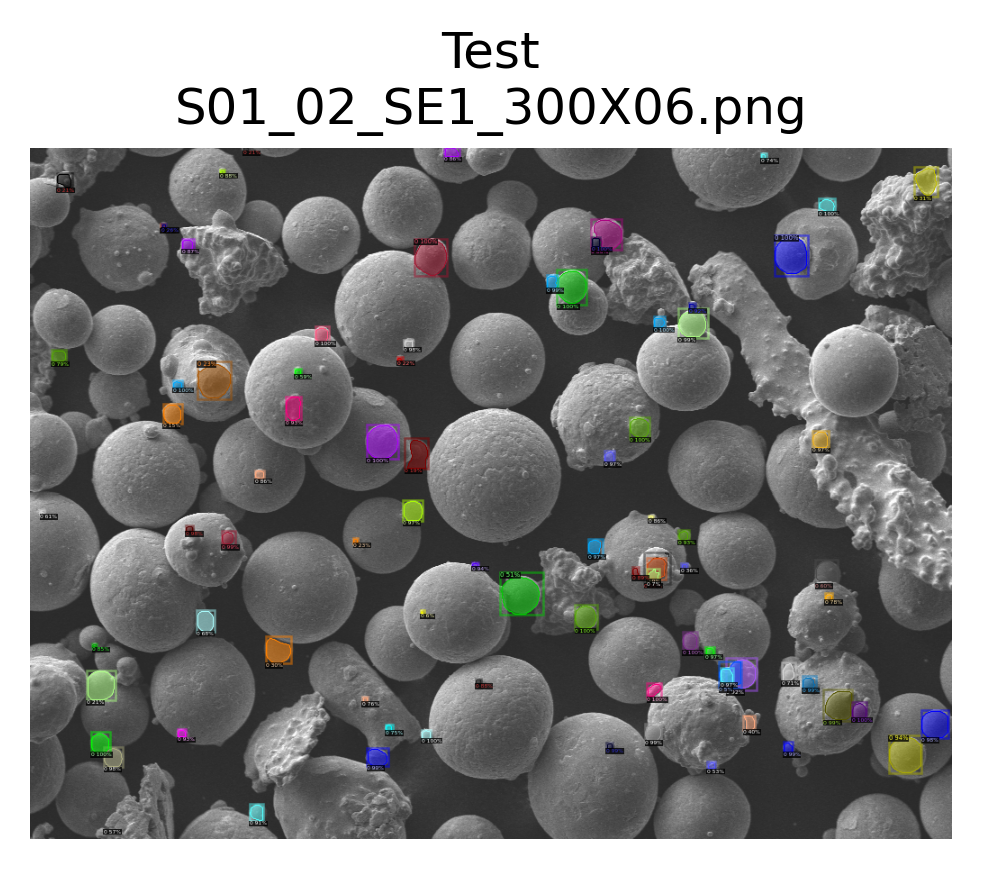

ddict info:
	path: ../Auto_annotate_images/S01_02_SE1_300X06.png
	num_instances: 84


In [11]:
img_path = Path('..', 'Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


We will now generate predictions on all of the images in the training and validation sets, and save the results for later.

In [1]:
results = []
for ds in cfg.DATASETS.TEST:
    print(f'Dataset: {ds}')
    for dd in DatasetCatalog.get(ds):
        print(f'\tFile: {dd["file_name"]}')
        img = cv2.imread(dd['file_name'])  # load image
        outs = predictor(img)  # run inference on image
        
        # format results for visualization and store for later
        results.append(data_utils.format_outputs(dd['file_name'], ds, outs))

        # visualize results
        visualize.display_ddicts(outs, None, ds, gt=False, img_path=dd['file_name'])

# save to disk
#with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
#    pickle.dump(results, f)

NameError: name 'cfg' is not defined

In [ ]:
files = os.listdir('Auto_annotate_images')
img_names = []
for f in files:
    if f.split('.')[0] != '250x' and f.split('.')[0] != '500x':
        img_names.append(f.split('.')[0])
        
results = []
for f in img_names:
    print("Annotating: " + f)
    img_path = Path('Auto_annotate_images', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement

# save to disk
with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
    pickle.dump(results, f)